In [1]:
%load_ext autoreload

In [7]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from functools import partial
from tqdm.auto import tqdm
from jax.experimental.optimizers import adam, momentum
import jax.experimental.stax as stax
from jx.utils import progress_bar_scan
from jax.config import config
config.update("jax_enable_x64", True)

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['figure.figsize'] = (11, 7)

In [3]:
ou = dict(
    drift = lambda y, t, p: p['theta'] * (p['mu'] - y),
    diffusion = lambda y, t, p: jnp.exp(p['sigma'])
)

def noise(key, dt):
    return jax.random.normal(key) * jnp.sqrt(dt)

In [94]:
def _sdeint_carry_euler(drift, diffusion, params, y, x):
    dt, i, k = x
    y = y + drift(y, i * dt, params) * dt + diffusion(y, i * dt, params) * noise(k, dt)
    return y, y

def _sdeint_carry_milstein(drift, diffusion, params, y, x):
    dt, i, k = x
    dfn = diffusion(y, i * dt, params)
    dfn_grad = jax.grad(diffusion)(y, i * dt, params)
    dW = noise(k, dt)
    y = y + drift(y, i * dt, params) * dt + dfn * dW + 0.5 * dfn * dfn_grad * (dW**2 - dt)
    return y, y

def sdeint(sde, y0, t, params, key, method='euler'):
    
    if method == 'euler':
        _sdeint_carry = _sdeint_carry_euler
    elif method == 'milstein':
        _sdeint_carry = _sdeint_carry_milstein
    else:
        raise

    dts = jnp.concatenate((jnp.zeros(1), jnp.diff(t)))
    sdeint_carry = partial(_sdeint_carry, sde['drift'], sde['diffusion'], params)
    carry, y = jax.lax.scan(sdeint_carry, y0, (dts, jnp.arange(len(t)), jax.random.split(key, len(t))))
    return y

In [95]:
params_true = dict(
    theta=0.7,
    mu=1.5,
    sigma=jnp.log(0.1),
)

params = dict(
    theta=1.,
    mu=1.,
    sigma=0.,
)

In [ ]:
key = jax.random.PRNGKey(0)

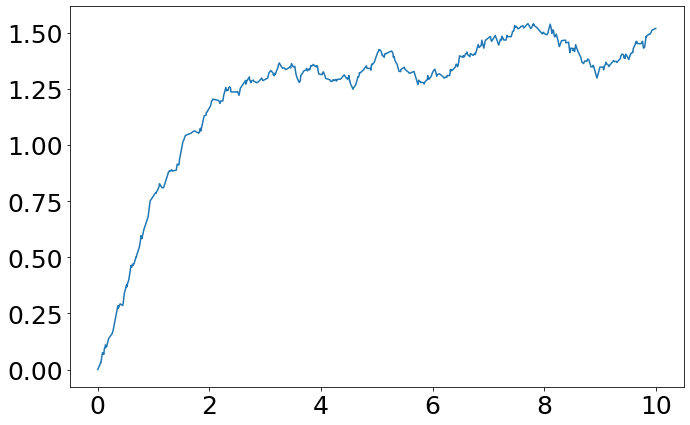

In [218]:
x = np.sort(jax.random.uniform(key, minval=0., maxval=10., shape=(500,)))
y = sdeint(ou, 0., x, params_true, key, method='milstein')
plt.plot(x, y)

In [219]:
key = jax.random.PRNGKey(0)
run_sde = jax.jit(lambda p, k: sdeint(ou, y[0], x, p, k, method='euler'))
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

In [220]:
opt_init, opt_update, get_params = momentum(1e-4, 0.9)
opt_state = opt_init(params)

niter = 1000
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

opt_state, losses = jax.lax.scan(
    pbar(step), 
    opt_state, 
    (jnp.arange(niter), keys)
)

params = get_params(opt_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [231]:
.shape

(2, 500)

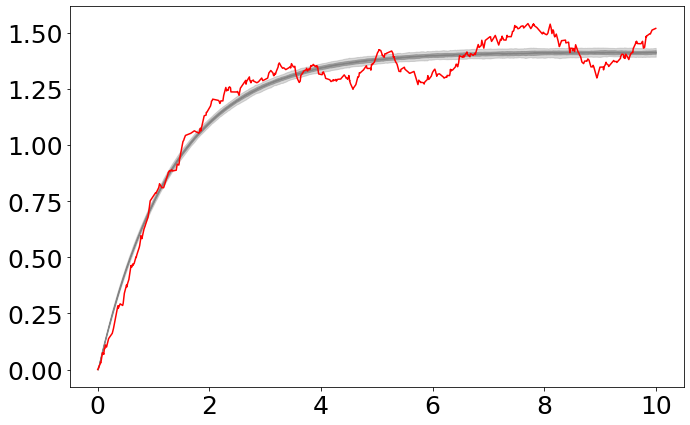

In [236]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')

In [238]:
drift_init, drift_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

diffusion_init, diffusion_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

In [239]:
ou_nn = dict(
    drift = jax.jit(lambda y, t, p: drift_apply(p['drift'], y)[0][0]),
    diffusion = jax.jit(lambda y, t, p: diffusion_apply(p['diffusion'], y)[0][0])
)

In [241]:
run_sde = jax.jit(lambda p, k: sdeint(ou_nn, y[0], x, p, k, method='euler'))
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

In [242]:
key, k1, k2 = jax.random.split(key, 3)
_, p_drift_init = drift_init(k1, (1,))
out_shape, p_diffusion_init = diffusion_init(k2, (1,))
nn_params = dict(
    drift = p_drift_init,
    diffusion = p_diffusion_init,
)

In [243]:
opt_init, opt_update, get_params = adam(1e-3)
opt_state = opt_init(nn_params)

niter = 1000
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

losses = []
for i in (pbar := tqdm(range(niter))):
    opt_state, loss = step(opt_state, (i, keys[i]))
    if i % 50 == 0:
        pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

# opt_state, losses = jax.lax.scan(
#     pbar(step), 
#     opt_state, 
#     (jnp.arange(niter), keys)
# )

nn_params = get_params(opt_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

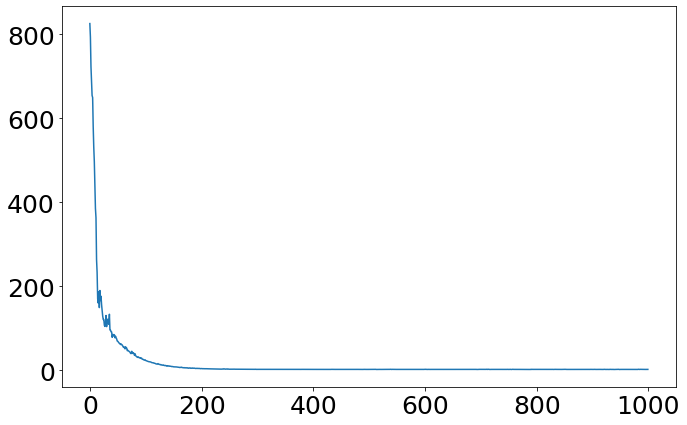

In [244]:
plt.plot(losses)

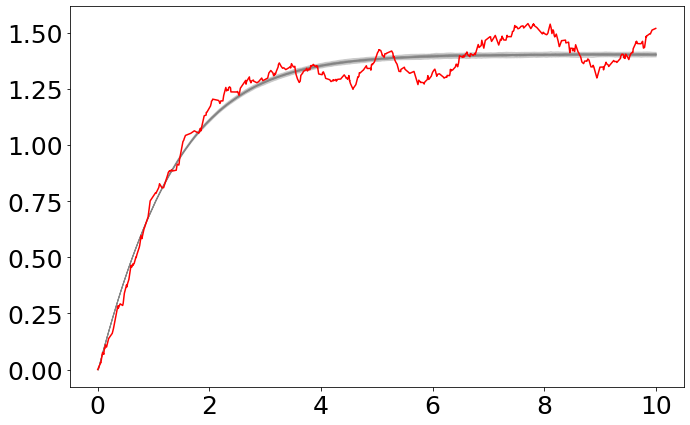

In [245]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(nn_params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')